## Build Schema

In [1]:
from sqlalchemy import *
#engine = create_engine('sqlite:///result/test.db')
engine = create_engine('sqlite://', echo=False)
metadata = MetaData()

users = Table('users', metadata,
    Column('user_id', String(15), primary_key=True),
    Column('gender_cd', Integer, nullable=False),
    Column('age', Integer, nullable=False),
    Column('foreigner_yn', String(1), nullable=False),
    Column('os_type', String(1), nullable=False)
)

dutchpay_claim = Table('dutchpay_claim', metadata,
    Column('claim_id', Integer, primary_key=True),
    Column('claim_at', DateTime, nullable=False),
    Column('claim_user_id', String(15), ForeignKey("users.user_id"), nullable=False)
)

dutchpay_claim_detail = Table('dutchpay_claim_detail', metadata,
    Column('claim_detail_id', Integer, primary_key=True),
    Column('claim_id', Integer, ForeignKey("dutchpay_claim.claim_id"), nullable=False),
    Column('recv_user_id', String(15), ForeignKey("users.user_id"), nullable=False),
    Column('claim_amount', Integer, nullable=False),
    Column('send_amount', Integer, nullable=True),
    Column('status', Enum(*['CLAIM','CHECK','SEND']), nullable=False)
)

a_payment_trx = Table('a_payment_trx', metadata,
    Column('id', String(37), primary_key=True),
    Column('transaction_id', Integer, nullable=False),
    Column('transacted_at', DateTime, nullable=False),
    Column('payment_action_type', Enum(*['PAYMENT','CANCEL']), nullable=False),
    Column('user_id', String(15), ForeignKey("users.user_id"), nullable=False),
    Column('amount', Integer, nullable=False)
)

#metadata.drop_all(engine)
metadata.create_all(engine)

Visualization (Pycharm db tool)

![ER diagram](./result/diagram.png)

## Build DB

In [2]:
import pandas as pd
def load_data(conn, path, table_name):
    df = pd.read_csv(f'{path}{table_name}.csv')
    df.sort_values(df.columns[0], ascending = True, inplace=True)
    df.to_sql(table_name, index=False, con=conn, if_exists='append')
    df_test = pd.read_sql(f'SELECT * FROM {table_name}', conn)
    if not df.set_index(df.columns[0]).equals(df_test.set_index(df_test.columns[0])):
        print(f'{table_name} : Error')
        print(len(df), len(df_test))
        print(df.compare(df_test))

path = 'data/DS_사전과제_v2/'
for table_name in engine.table_names():
    load_data(engine, path, table_name)

## Query

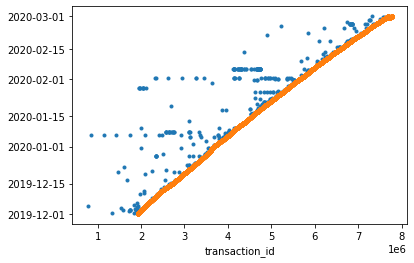

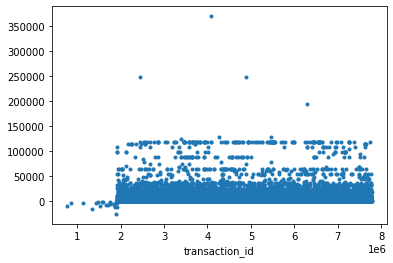

In [3]:
import matplotlib.pyplot as plt
def vis_cancel(df):
    df2 = df.set_index(['transaction_id','payment_action_type'])
    df2 = df2.sort_index()
    pd.to_datetime(df2.transacted_at[:,'CANCEL']).plot(style='.')
    pd.to_datetime(df2.transacted_at[:,'PAYMENT']).plot(style='.')
    plt.figure()
    (df2.amount[:,'PAYMENT'].sub(df2.amount[:,'CANCEL'],fill_value=0)).plot(subplots=False,style='.')

sql = '''
SELECT distinct users.user_id, transaction_id, transacted_at, payment_action_type, amount
FROM users
    INNER JOIN dutchpay_claim dc ON (users.user_id = dc.claim_user_id)
    INNER JOIN a_payment_trx dc ON (users.user_id = dc.user_id)
;
'''
df = pd.read_sql_query(sql, con=engine)
vis_cancel(df)

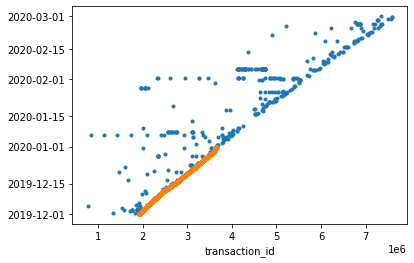

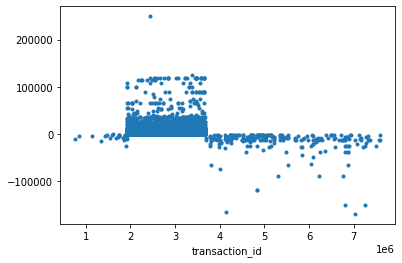

In [4]:
sql = '''
select * 
from (
    SELECT distinct users.user_id, transaction_id, transacted_at, payment_action_type, amount
    FROM users
        INNER JOIN dutchpay_claim dc ON (users.user_id = dc.claim_user_id)
        INNER JOIN a_payment_trx dc ON (users.user_id = dc.user_id)
    )
where( 
    transacted_at >= '2019-12-01 00:00:00' 
    and
    transacted_at < (
        case when payment_action_type = 'PAYMENT' then '2020-01-01 00:00:00'
        else '2020-03-01 00:00:00'
        end
    ))
'''
df = pd.read_sql_query(sql, con=engine)
vis_cancel(df)

In [5]:
sql = '''
select 
    user_id, transaction_id, 
    sum ( (case when payment_action_type = 'PAYMENT' then 1 else -1 end) * amount ) as net_amount
from (
    SELECT distinct users.user_id, transaction_id, transacted_at, payment_action_type, amount
    FROM users
        INNER JOIN dutchpay_claim dc ON (users.user_id = dc.claim_user_id)
        INNER JOIN a_payment_trx dc ON (users.user_id = dc.user_id)
    )
where( 
    transacted_at >= '2019-12-01 00:00:00' 
    and
    transacted_at < (
        case when payment_action_type = 'PAYMENT' then '2020-01-01 00:00:00'
        else '2020-03-01 00:00:00'
        end
    ))
group by transaction_id
HAVING net_amount > 0;
'''
df = pd.read_sql_query(sql, con=engine)
df

,user_id,transaction_id,net_amount
0,cd6200e10452b97,1924318,99000
1,1415199f244ebae,1925014,1200
2,cd6200e10452b97,1925075,99000
3,cd6200e10452b97,1925702,11000
4,cd6200e10452b97,1925721,11000
...,...,...,...
8601,6786c85fb1c9ab2,3675165,2500
8602,56ebfa41c6421f1,3675451,2500
8603,789f9768fe95cca,3675470,1200
8604,5709b52af8f4b36,3676131,2500


In [49]:
sql = '''
select user_id, sum(net_amount) as net_amount_per_user
from(
    select 
        user_id, transaction_id, 
        sum ( (case when payment_action_type = 'PAYMENT' then 1 else -1 end) * amount ) as net_amount
    from (
        SELECT distinct users.user_id, transaction_id, transacted_at, payment_action_type, amount
        FROM users
            INNER JOIN dutchpay_claim dc ON (users.user_id = dc.claim_user_id)
            INNER JOIN a_payment_trx dc ON (users.user_id = dc.user_id)
        )
    where( 
        transacted_at >= '2019-12-01 00:00:00' 
        and
        transacted_at < (
            case when payment_action_type = 'PAYMENT' then '2020-01-01 00:00:00'
            else '2020-03-01 00:00:00'
            end
        ))
    group by transaction_id
    HAVING net_amount > 0
)
group by user_id
'''
df = pd.read_sql_query(sql, con=engine)
df_result = df.set_index(['user_id'])

In [53]:
# For validation

df_target = pd.read_sql_query('select * from dutchpay_claim', con=engine)
df_target = df_target.claim_user_id
df_dutch_uids = df_target.copy()

df_target = pd.read_sql_query('select * from a_payment_trx', con=engine)
#df_target = df_target[ df_target.payment_action_type == 'PAYMENT' ]
df_target = df_target[ df_target.user_id.isin(df_dutch_uids.values) ]

df_target = df_target[df_target.transacted_at>='2019-12-01 00:00:00']
df_target = df_target[
    ((df_target.transacted_at<'2020-03-01 00:00:00') & (df_target.payment_action_type=='CANCEL'))
    |((df_target.transacted_at<'2020-01-01 00:00:00') & (df_target.payment_action_type=='PAYMENT'))
]
df_target = df_target.pivot(columns='payment_action_type', index='transaction_id', values=['user_id','amount'])
df_target.dropna(subset=[('amount','PAYMENT')], inplace=True)
df_target['amount','CANCEL'].fillna(0, inplace=True)
df_target = pd.DataFrame( {
    'user_id' : df_target.user_id.PAYMENT.fillna(df_target.user_id.CANCEL),
    'net_amount' : df_target.amount.PAYMENT - df_target.amount.CANCEL
})
df_target = df_target[df_target.net_amount>0]
df_target = df_target.groupby('user_id').sum()
df_net_amount_uids = df_target.rename(columns={'net_amount':'net_amount_per_user'}).copy()

df_net_amount_uids.equals(df_result)

True

In [109]:
sql = '''
select user_id
from(
    select 
        user_id, transaction_id, 
        sum ( (case when payment_action_type = 'PAYMENT' then 1 else -1 end) * amount ) as net_amount
    from (
        SELECT distinct users.user_id, transaction_id, transacted_at, payment_action_type, amount
        FROM users
            INNER JOIN dutchpay_claim dc ON (users.user_id = dc.claim_user_id)
            INNER JOIN a_payment_trx dc ON (users.user_id = dc.user_id)
        )
    where( 
        transacted_at >= '2019-12-01 00:00:00' 
        and
        transacted_at < (
            case when payment_action_type = 'PAYMENT' then '2020-01-01 00:00:00'
            else '2020-03-01 00:00:00'
            end
        ))
    group by transaction_id
    HAVING net_amount > 0
)
group by user_id
HAVING sum(net_amount) >= 10000
'''
df = pd.read_sql_query(sql, con=engine)
df_result = df.set_index(['user_id'])
df_result

""
user_id
000e50dea88c5b6
004dbf063ae4c9d
006dd13085d37b1
009ec780db99659
00f307175b81c49
...
ff4ac2544fcc1dc
ffbabc5587021e2
ffdf2dc9ef29496


In [110]:
# For validation

df_target = pd.read_sql_query('select * from dutchpay_claim', con=engine)
df_target = df_target.claim_user_id
df_dutch_uids = df_target.copy()

df_target = pd.read_sql_query('select * from a_payment_trx', con=engine)
#df_target = df_target[ df_target.payment_action_type == 'PAYMENT' ]
df_target = df_target[ df_target.user_id.isin(df_dutch_uids.values) ]

df_target = df_target[df_target.transacted_at>='2019-12-01 00:00:00']
df_target = df_target[
    ((df_target.transacted_at<'2020-03-01 00:00:00') & (df_target.payment_action_type=='CANCEL'))
    |((df_target.transacted_at<'2020-01-01 00:00:00') & (df_target.payment_action_type=='PAYMENT'))
]
df_target = df_target.pivot(columns='payment_action_type', index='transaction_id', values=['user_id','amount'])
df_target.dropna(subset=[('amount','PAYMENT')], inplace=True)
df_target['amount','CANCEL'].fillna(0, inplace=True)
df_target = pd.DataFrame( {
    'user_id' : df_target.user_id.PAYMENT.fillna(df_target.user_id.CANCEL),
    'net_amount' : df_target.amount.PAYMENT - df_target.amount.CANCEL
})
df_target = df_target[df_target.net_amount>0]
df_target = df_target.groupby('user_id').sum()
df_target = df_target[df_target.values>=10000]
df_net_amount_uids = df_target.drop(columns=['net_amount']).copy()

print(df_net_amount_uids.equals(df_result))

True


## Optimization

In [101]:
%%timeit
sql = '''
SELECT user_id
FROM (
         SELECT user_id,
                transaction_id,
                sum((CASE WHEN payment_action_type = 'PAYMENT' THEN 1 ELSE -1 END) * amount) AS net_amount
         FROM (
                  SELECT distinct users.user_id, transaction_id, transacted_at, payment_action_type, amount
                  FROM users
                           INNER JOIN dutchpay_claim dc ON (users.user_id = dc.claim_user_id)
                           INNER JOIN a_payment_trx dc ON (users.user_id = dc.user_id)
              )
         WHERE (
                   transacted_at >= '2019-12-01 00:00:00'
                   AND
                   transacted_at < (
                       CASE
                           WHEN payment_action_type = 'PAYMENT' THEN '2020-01-01 00:00:00'
                           ELSE '2020-03-01 00:00:00'
                           END
                       )
               )
         GROUP BY transaction_id
         HAVING net_amount > 0
     )
GROUP BY user_id
HAVING sum(net_amount) >= 10000
'''
df = pd.read_sql_query(sql, con=engine)
df_result = df.set_index(['user_id'])

221 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
sql = '''
SELECT user_id
FROM (
         SELECT user_id,
                transaction_id,
                sum((CASE WHEN payment_action_type = 'PAYMENT' THEN 1 ELSE -1 END) * amount) AS net_amount
         FROM (
                  SELECT distinct users.user_id, transaction_id, transacted_at, payment_action_type, amount
                  FROM users
                           INNER JOIN dutchpay_claim dc ON (users.user_id = dc.claim_user_id)
                           INNER JOIN a_payment_trx dc ON (users.user_id = dc.user_id)
              )
         WHERE (
                   transacted_at >= '2019-12-01 00:00:00'
                   AND
                   transacted_at < (
                       CASE
                           WHEN payment_action_type = 'PAYMENT' THEN '2020-01-01 00:00:00'
                           ELSE '2020-03-01 00:00:00'
                           END
                       )
               )
         GROUP BY transaction_id
         HAVING net_amount > 0
     )
GROUP BY user_id
HAVING sum(net_amount) >= 10000
'''
with open('problem_2.sql', 'w') as fp:
    fp.write(sql)
with open('problem_2.sql', 'r') as fp:
    print(fp.read())


SELECT user_id
FROM (
         SELECT user_id,
                transaction_id,
                sum((CASE WHEN payment_action_type = 'PAYMENT' THEN 1 ELSE -1 END) * amount) AS net_amount
         FROM (
                  SELECT distinct users.user_id, transaction_id, transacted_at, payment_action_type, amount
                  FROM users
                           INNER JOIN dutchpay_claim dc ON (users.user_id = dc.claim_user_id)
                           INNER JOIN a_payment_trx dc ON (users.user_id = dc.user_id)
              )
         WHERE (
                   transacted_at >= '2019-12-01 00:00:00'
                   AND
                   transacted_at < (
                       CASE
                           WHEN payment_action_type = 'PAYMENT' THEN '2020-01-01 00:00:00'
                           ELSE '2020-03-01 00:00:00'
                           END
                       )
               )
         GROUP BY transaction_id
         HAVING net_amount > 0
     )
GROUP BY us